# Analysis of tweets involving the hashtag "#UN"
## Contents:
- [Motivation](#motivation)
- [Data acquisition and classification (.py files)](#acquisition-classification)
    * [Collecting tweets using snscrape](#collecting)
    * [Sentiment analysis using NLP](#sentiment)
- [Importing and formating data](#import-format)
- [Visualising raw data](#visualise-raw)
- [Sliding Window](#sliding-window)
- [Finding Keywords](#find-keywords)
    * [Cleaning the data](#cleaning)
    * [Selecting and recording recurrent words](#selecting)
- [Finding "biggest" trends: PCA](#find-PCA)
    * [All tweets](#all-PCA)
    * [Positive tweets](#positive-PCA)
- [Finding "biggest" trends: Hierarchical Clustering](#find-clustering)
- [Summary](#summary)

## Motivation <a class="anchor" id="motivation"></a>

NOTE: Written on 2nd of March 2022.

In recent days I have found my twitter feed replete of news regarding the recent events taking place in Ukraine. While I follow some news outlets, most of the accounts I follow are either people I know or related to learning Japanese language. This trend made me curious as to how much twitter can be used to track world political events, and whether I could discover past political events using just twitter. I simplistically thought of which keyword could relate to such events and decided upon "#UN" relating to the United Nations. In principle this organisation was established to serve as a forum for discussion between nations and thus it would be reasonable that twitter users would reference the UN during major political world events (Official website: https://www.un.org/en/).

I decided to work with a moderate dataset covering all tweets using "#UN" since January 2021 and see what results I could extract from there. Indeed as can be seen by the end of my analysis, it may now be sensible to include tweets tagging the user "@UN" or extending the time frame of my analysis. Nonetheless, as an initial pilot I am happy with the results.

It is important to acknowledge that as analysis are made by humans, they will fundamentally be biased. I have made my greatest effort to be as unbiased as possible in my analysis and writing, while understanding that removing all bias is likely impossible. This may result in a somewhat dispassionate tone regarding major events which bring great suffering to many people, yet it is not the purpose of this project to bring about a political message and for that reason I find this approach the most appropriate.

In [7]:
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm_notebook

## Data acquisition and classification (.py files) <a class="anchor" id="acquisition-classification"></a>

### Collecting tweets using snscrape <a class="anchor" id="collecting"></a>

I initially tried using the tweepy package which makes use of the official twitter API through a developer account. However, I found that unless one owns an academic account it is not possible to obtain a sizeable number of tweets without encountering download cap restrictions.

I therefore explored a bit further and decided to use 'snscrape' (https://github.com/JustAnotherArchivist/snscrape) which does not require the creation of an account and does not restrict the amount of data that can be downloaded (or if it does I never reached such a limit). Note that one restriction of using snscrape is that as it lacks authentification with Twitter it is not possible to obtain user data regarding 'following' and 'followers'. Helpfully snscrape has also been packaged into python so I could import the package into python rather than run unix command lines.

NOTE: The code below is a regular ".py" python script, and not usually a part of this notebook. I include it here simply to make evident my approach. For my chosen parameters, this script took about 2 hours to complete, obtaining tweets from approximately 400 days.

In [2]:
# proj1_script_a_collect_data.py

import os
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import snscrape.modules.twitter as sntwitter
from tqdm import tqdm

# Use snscrape to collect tweets, more useful for this than the official twitter API as one isn't restricted in
# how many tweets to download, etc.
def get_tweets(init_date, end_date, query):
    tweets_list = []
    # Scrape data and append tweets to list
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(
        query + ' since:'+init_date+' until:'+end_date+'').get_items()):
        if i>1000000:
            print("Error: too many tweets")
            break
        tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.user.id, tweet.lang])
    # Labelling
    tweets_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'User Id', 'Language'])
    
    return(tweets_df)

# Set up regular time intervals to download tweets, just useful to cut up the data as one can then easily collect
# more data in the future or past, also in case there's an error it would only affect one file out of many, and
# make it easier to pinpoint what happened.
def get_date_range(start_date,sectSize):
    # start_date = '20210101'
    date_format = '%Y%m%d'
    dtObj = datetime.strptime(start_date, date_format)
    numDays = datetime.today().date()-dtObj.date()
    sectSize = 10
    numSections = np.floor(numDays.days/sectSize).astype(np.int16)
    
    # Make sure data is properly labelled by time for future reference and to incorporate with more data
    dateList = [(dtObj + relativedelta(days=i*sectSize)).date() for i in range(numSections)]
    dateList_string = [dateList[i].strftime(date_format)+'-'
                       +(dateList[i+1]-relativedelta(days=1)).strftime(date_format) for i in range(len(dateList)-1)]
    return(dateList,dateList_string)

# Collect and save the tweets into CSV
def collect_save_tweets(dateList, dateList_string,query):
    for i in tqdm(range(len(dateList)-1)):
        sect_tweets = get_tweets(str(dateList[i]),str(dateList[i+1]),query)
        sect_tweets.to_csv('data_tweets/un_mentions_'+dateList_string[i]+".csv",
                            index=False)

if not os.path.exists('data_tweets'): os.makedirs('data_tweets')
# This takes about 2 hours for approx 400 days, roughly 200 days/hour
dateList, dateList_string = get_date_range('20210101', 10)
collect_save_tweets(dateList, dateList_string, "#UN")

  0%|                                                                                 | 0/42 [02:07<?, ?it/s]

KeyboardInterrupt



### Sentiment analysis using NLP <a class="anchor" id="sentiment"></a>
I took a course on NLP processing and got an understanding of what tools are out there and what they can be used for. When looking at the tweets I had collected I reasoned that they are ideal for sentiment classification because by construction Tweets limited by the number of characters, which should make sentiment classification easier.

I accessed the fabulous resource "Hugging Face" (https://huggingface.co/) which provides pre-trained models and datasets for training, and downloaded one of the most popular sentiment classification models, trained specifically on Twitter data: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment.

I performed some initial tests on my tweets where I observed the results from the classifier into Neutral, Positive or Negative and subjectively decided whether the classification is accurate. I found it to be the case and thus did not find it necessary to train the data further. It is possible that I could make the classifier more accurate and Hugging Face provides an easy setup to training models on new data, but I decided that the gains would be minimal and as with many deep learning models I may need to provide many new training examples to significantly improve the model which is not really the aim of this project, especially as the provided model already performs very well.

NOTE: The code below is a regular ".py" python script, and not usually a part of this notebook. I include it here simply to make evident my approach. This script took about 4 hours to finish for my chosen date range and parameters.

In [ ]:
# proj1_script_b_classify_sentiment.py

import os
import numpy as np
import pandas as pd
import re
from tqdm import tqdm

# Libraries from Huggingface to download the transformer and classify in a simple way
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks: emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
# tokenizer = AutoTokenizer.from_pretrained("../twitter-roberta-base-sentiment")

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
# model = AutoModelForSequenceClassification.from_pretrained("../twitter-roberta-base-sentiment")

def get_sentiment_tweet(text_input):
    text = preprocess(text_input)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return(scores)

def get_list_files(tweet_dir):
    list_files_raw = np.array(os.listdir(tweet_dir))
    list_files = np.sort(list_files_raw[['un_mentions_202' in file for file in list_files_raw]])
    return(list_files)

tweet_dir = 'data_tweets/'
list_files = get_list_files(tweet_dir)

# Get tweet list, classify them using the sentiment trained transformer and save as csv
# This will take about 4 hours
for file in tqdm(list_files):
    raw_data = pd.read_csv(tweet_dir+file,lineterminator='\n')
    list_tweets = raw_data[raw_data['Language'] == 'en'].reset_index(drop=True)
    sentiment_list = pd.DataFrame([get_sentiment_tweet(tweet) for tweet in tqdm(list_tweets['Text'])])
    list_tweets[['Negative','Neutral','Positive']] = sentiment_list
    list_tweets.to_csv(tweet_dir + re.sub('un_mentions','un_mentions_processed',file),index=False)


## Importing and formating data <a class="anchor" id="import-format"></a>
I import the CSV data and proceed to assign each tweet a sentiment from our previous results as they seem to be relatively conclusive with minimal errors. I also rearrange the dataframe slightly and remove 'https' from the tweets as I will not be at the moment analysing which websites tweets direct to, often these addresses simply relate to the location of an attached image. I make some effort to remove bot tweets by removing duplicate tweets, this does not work on more sophisticated bots that use deep learning to redact similar but different tweets will escape this process. In a sense if an effort is made to buy/produce such bots it may be worth recording as a "feature" rather than a "bug".

In [8]:
def simplify_dates(datasetT):
    datasetT['Datetime'] = [datetime.datetime.strptime(re.sub('\+00:00','',i), date_format) for i in datasetT['Datetime']]
    return datasetT
    
def round_sentiments(datasetT):
    datasetT[['Negative','Neutral','Positive']] = np.rint(datasetT[['Negative','Neutral','Positive']])
    return datasetT

In [9]:
# This function imports the dataset and tidies up the sentiments a bit
def get_cleaned_df(file_read):
    dataset = pd.read_csv(file_read,lineterminator='\n')
    dataset = simplify_dates(dataset)
    dataset = round_sentiments(dataset)
    dataset = dataset.iloc[::-1].reset_index(drop=True)
    return dataset

In [10]:
# I found it easier to just have a single column with the sentiment associated to that tweet
def tidy_data(tweetdir,list_files):
    full_set = pd.concat([get_cleaned_df(tweet_dir + file) for file in list_files], ignore_index=True)
    full_set['Text'] = [re.sub('https.*','', line) for line in full_set['Text']]
    full_set = full_set.drop_duplicates(subset=['Text']).reset_index(drop=True)
    sentiment_column = np.full(len(full_set),'        ')
    sentiment_column[full_set['Negative'] == 1.0] = 'Negative'
    sentiment_column[full_set['Positive'] == 1.0] = 'Positive'
    sentiment_column[sentiment_column == '        '] = 'Neutral'
    full_set.insert(6, "Sentiment", sentiment_column, True)
    return(full_set)

In [11]:
tweet_dir = './data_tweets/'
date_format = '%Y-%m-%d %H:%M:%S'
list_files_raw = np.array(os.listdir(tweet_dir))
list_files = np.sort(list_files_raw[['un_mentions_processed' in file for file in list_files_raw]])
full_set = tidy_data(tweet_dir,list_files)

## Visualising raw data <a class="anchor" id="visualise-raw"></a>
As a first approach, I thought it could be interesting to plot what time of the day and week tweets took place. According to a study by this blog called Bluffer (https://buffer.com/resources/best-time-to-tweet-research/), the most popular time to tweet is 13h. They have not really disclosed their data or overall approach for obtaining this data but seems to be consistent with other website's conclusions so I will take that as the baseline. Unfortunately snscrape does not provide the possibility to sort by timezone, therefore all the data I have collected is by default normalised to London GMT.

Now when looking at the tweets I have collected, I can sort them out by sentiment, maybe negative or positive tweets have different schedules. Indeed there is research which suggests this is the case [Shah *et al*, (2019). *J Med Internet Res*. 21(5):e12881. https://doi.org/10.2196/12881 ].

In [12]:
# Extract just the time and convert to hours
def get_day_counts(input_set):
    timeList = [timestamp.time() for timestamp in input_set]
    list_in_day = np.array([(t.hour * 60 + t.minute) * 60 + t.second for t in timeList])/3600
    return list_in_day

# Convert to day of the week and put on a range from 0 to 7 depending on day and time.
def get_week_counts(input_set):
    dayList = np.array([timestamp.weekday() for timestamp in input_set])
    list_in_week = dayList + get_day_counts(input_set)/24
    return list_in_week

# Get how many tweets happen in a week or day, to find patterns
list_all_day = get_day_counts(full_set['Datetime'])
list_all_week = get_week_counts(full_set['Datetime'])

# Group into a single dataframe for convenience
repeat_timescales = pd.concat([pd.DataFrame(list_all_day,columns=['Daily']),
                               pd.DataFrame(list_all_week,columns=['Weekly']),
                               full_set['Sentiment']],axis=1)

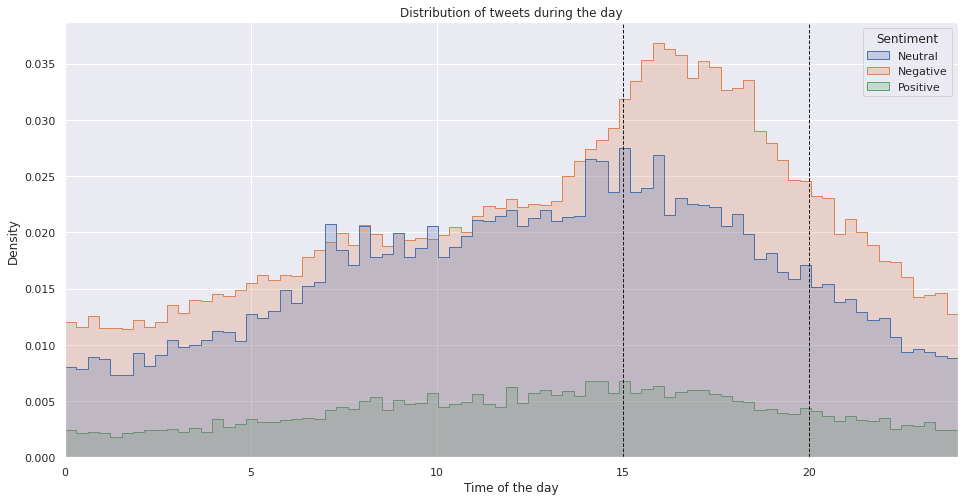

In [13]:
sns.set(rc = {'figure.figsize':(16,8)})
ax = sns.histplot(data=repeat_timescales, x='Daily', hue='Sentiment', stat="density", element="step")
ax.set_xlim([0,24]);
ax.set(xlabel='Time of the day', title='Distribution of tweets during the day');
plt.axvline(15, color='k', linestyle='dashed', linewidth=1);
plt.axvline(20, color='k', linestyle='dashed', linewidth=1);

First of all it's evident that there are more negative tweets overall, followed by neutral tweets and then by positive tweets which constitute a small proportion of the overall number. The interpretations may be varied, as we cannot determine whether this means the users are overall more negative oriented, or informations and news coverage where users are informed are more negative, or actual events relating to the UN are more negative. It may be a combination of factors or other factors I have not considered, the answer to this question is beyond the scope of this project and I will limit to confirming that overall sentiments regarding the UN on twitter are more negative than positive.

I find as expected that the distribution of tweets is not uniform throughout the day. Indeed the most popular time of the day is not too far off from what we expected. The two vertical bars indicate the ranges of noon in the US, this is relevant as analysis from the company Statista suggests there are more overall users in the US which as we have filtered by english language will affect our data (https://www.statista.com/statistics/242606/number-of-active-twitter-users-in-selected-countries/). What is somewhat more remarkable is a clear difference in time of the day tweeting for negative sentiment tweets involving the united nations. I do not find it necessary to fit a peak to this distribution as it is evident that the most popular time of day for negative tweers is roughly 17h GMT.

One can make different hypotheses as to why this may be the case, maybe people have just spent some time reading the news are more irritable, whereas earlier on they have not yet read the news. Alternatively it may be that Europeans (at an earlier time zone) tweet more negatively. It would be difficult for me to pinpoint the reason, the work highlighted above outlines a different distribution for negative tweets, which suggests this may be something specific to the tweets we have collected or that these tweets are a subset of some other, greater overall trend. In future it would be sensible to compare with other hashtags that relate to world political events, to find whether this is a general feature of tweets in this topic.

I perform below a simple "Skewness" analysis on the data which will indicate how much the data deviates from a normal distribution in a particular direction. This is simply the 3rd standardized moment, and serves as a sanity check to what we see above, in a similar way as the mean or variance serve similar purposes: https://en.wikipedia.org/wiki/Standardized_moment. We find with negative skewness that all distributions are shifted to the right, with the Negative sentiment distribution shifted substantially more to the right as indicated by the greater absolute value of its skewness.

In [14]:
from scipy.stats import skew

def get_skewness(sentiment):
    return str(np.round(skew(repeat_timescales[repeat_timescales['Sentiment'] == sentiment]['Daily']),2))

print('Neutral skewness: '+get_skewness('Neutral'))
print('Positive skewness: '+get_skewness('Positive'))
print('Negative skewness :'+get_skewness('Negative'))

Neutral skewness: -0.18
Positive skewness: -0.18
Negative skewness :-0.34


I then perform a similar analysis on data ordered by days of the week. First one can note that the trend seen above relating to later than average negative tweets is preserved in this day-specific figure. When analysing the days of the week, one can see that there is less activity on Saturdays and Sundays compared to the rest of the week. The study cited above has not found such a difference. As above it may be worth investigating if this is a trend relating to political tweets. I am not a sociologist, one speculative explanation could be that maybe users feel less engaged on the weekend when they spend time relaxing, but I would not make any ascertations from this data without consulting someone more educated on these matters.

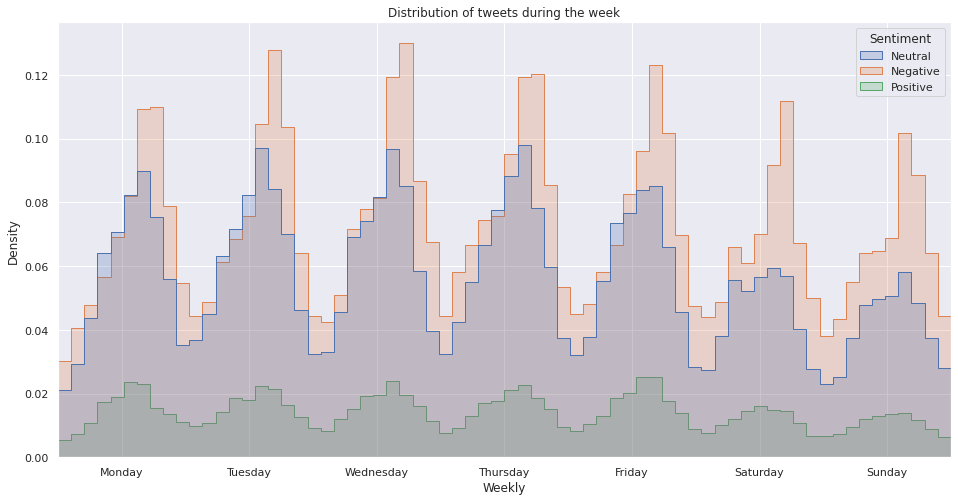

In [15]:
sns.set(rc = {'figure.figsize':(16,8)})
wPlot = sns.histplot(data=repeat_timescales, x='Weekly', hue='Sentiment', stat="density", element="step",)
wPlot.set_xticks(np.arange(0.5,7.5,1))
wPlot.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);
wPlot.set_xlim([0,7]);
wPlot.set(title='Distribution of tweets during the week');

## Sliding Window <a class="anchor" id="sliding-window"></a>

I apply what is often termed a "sliding window" which is useful for smoothing out the data, but also in organising the data into more manageable time slots. This is a relatively common technique, and while there are packages for implementing it, I often find it more versatile to implement it myself. For this dataset I've chose a sliding window of 72h and a step size for the window to slide of 1h, this feels like overkill as it will be a very fine-grained analysis, but it's still manageable for this size of dataset.

In [16]:
# I use a sliding window to smooth out the data and analyse time intervals easier
def get_sliding_window_pos(start_date_string, window_size, step_size):
    start_date = datetime.datetime.strptime(start_date_string, date_format)
    window_index = np.array([[start_date + relativedelta(hours=i), 
                     start_date + relativedelta(hours=i*step_size) + relativedelta(hours=window_size)]
                    for i in range(24*10*len(list_files) - window_size)])
    return(window_index)

In [17]:
# This function collects the number of overall, as well as sentiment specific tweets on the sliding window
def get_window_number_sentiment(window_index):
    window_index_result = []
    all_tweet_num = []
    for window_pos in tqdm_notebook(window_index):
        window_index_result.append((window_pos[0] <= full_set['Datetime']) & (full_set['Datetime']  < window_pos[1]))
        window_tweets = full_set[(window_pos[0] <= full_set['Datetime']) & (full_set['Datetime']  < window_pos[1])]
        tot_tweets = len(window_tweets)
        neg_tweets = len(window_tweets[window_tweets['Sentiment'] == 'Negative'])
        pos_tweets = len(window_tweets[window_tweets['Sentiment'] == 'Positive'])
        all_tweet_num.append([window_pos[1],tot_tweets,neg_tweets,tot_tweets-neg_tweets,pos_tweets])
    all_tweet_num = pd.DataFrame(all_tweet_num)
    all_tweet_num.set_axis(['Datetime', 'All', 'Negative', 'Neutral', 'Positive'], axis=1, inplace=True)
    return (all_tweet_num, window_index_result)

In [18]:
start_date_string = '2021-01-01 00:00:00'
window_index = get_sliding_window_pos(start_date_string, window_size = 72, step_size = 1)
window_tweet_num, window_index_result = get_window_number_sentiment(window_index)

  0%|          | 0/10008 [00:00<?, ?it/s]

One can then visualise the result of the sliding window, for example observing the number tweets over time, classified into different sentiments. A few peaks are already observable, and while one could already manually look into each specific peak and sort through the data to look for trends, I will perform a more automated approach which should then be easy to extrapolate to other datasets.

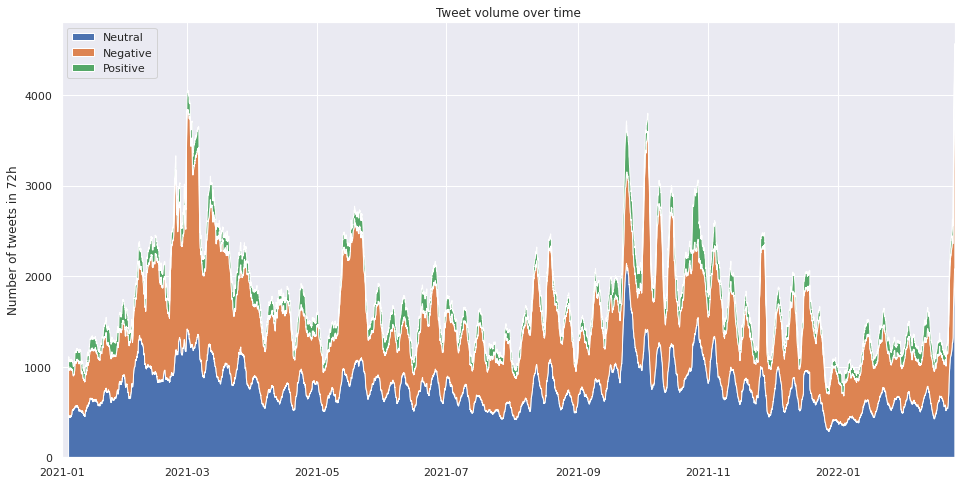

In [19]:
sns.set(rc = {'figure.figsize':(16,8)})
fig, ax = plt.subplots()
ax.stackplot(np.array(window_tweet_num['Datetime']), np.array(window_tweet_num[['Neutral','Negative','Positive']]).T,
            labels = ['Neutral','Negative','Positive'])
ax.set_xlim([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 2, 25)]);
ax.set(ylabel='Number of tweets in 72h', title='Tweet volume over time', label=["Fibonacci ", "Evens", "Odds"]);
ax.legend(loc='upper left');

## Finding keywords <a class="anchor" id="find-keywords"></a>
### Cleaning the data <a class="anchor" id="cleaning"></a>
I make use of the nltk (natural language toolkit) in python as it saves me having to implement some standard natural processing functions. I can then tokenise data and remove stopwords (*ie* and, at, etc.) and punctuation marks to leave only the words I'm interested in. There are in adition a few other words that are not considered stopwords by nltk, instead of looking for further libraries, I realised there were not that many so I just removed them by hand. I also decide to make everything lowercase as many twitter users decide to use only underscores or only capital letters and I want to count those words as the same.

In [20]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
nltk.download('punkt')

import string
stop = set(stopwords.words('english') + list(string.punctuation))
stop.update(['’','https','un','amp','``',"''","'s",'..','...',"n't",'--','”','–','//','“','like','also','put','ask','w/','unitednations'])

def clean_sentence(sentence):
    cleaned = [i for i in word_tokenize(sentence.lower()) if i not in stop]
    return np.array(cleaned)

[nltk_data] Downloading package stopwords to /home/eggman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/eggman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
words_List = np.array([clean_sentence(text) for text in tqdm_notebook(full_set['Text'])])

  0%|          | 0/226286 [00:00<?, ?it/s]

/tmp/ipykernel_589647/1166846965.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  words_List = np.array([clean_sentence(text) for text in tqdm_notebook(full_set['Text'])])


In [22]:
from collections import Counter
import sys

### Selecting and recording recurrent words <a class="anchor" id="selecting"></a>
I make a word list, in order to not take every word that appears but still be thorough, I take any word that appeared at least a fixed amount of times at any point in the 72h sliding window. All of these words will not be analised but it could be useful to see if some words appeared at all outside of when they appeared in great numbers. This number can be reduced to reduce analysis time, especially with bigger datasets. With the current parameters this step takes approximately 7 minutes.

In [23]:
def get_words_in_window(condition, min_times):
    top_words_list = []
    for window_pos in tqdm_notebook(window_index_result):
        top_words = Counter(np.hstack(words_List[window_pos & condition])).most_common()
        top_words = [tup for tup in top_words if tup[1] >= min_times]
        top_words_list.append(top_words)

    return(top_words_list)

In [24]:
min_times = 5
top_words_pos = get_words_in_window(full_set['Sentiment'] == 'Positive', min_times)
top_words_neg = get_words_in_window(full_set['Sentiment'] == 'Negative', min_times)
top_words_neu = get_words_in_window(full_set['Sentiment'] == 'Neutral', min_times)
top_words_tot = get_words_in_window(1, min_times)

  0%|          | 0/10008 [00:00<?, ?it/s]

  0%|          | 0/10008 [00:00<?, ?it/s]

  0%|          | 0/10008 [00:00<?, ?it/s]

  0%|          | 0/10008 [00:00<?, ?it/s]

I then obtain the top 10 words at each position along the sliding window, I decided to go by top words rather than above a certain threshold in order to detect even small peaks that may not have the impact of very tweeted about news but still be significant. I further obtain how those words have appeared over time in the timeframe of the data.

In [25]:
def get_top10_window(top_words_list):
    top10_list = []
    for pos in tqdm_notebook(top_words_list):
        top10 = [i[0] for i in pos[:10]]
        top10_list = top10_list + top10

    top10_list = list(dict.fromkeys(top10_list))
    return(top10_list)

In [26]:
top10_pos = get_top10_window(top_words_pos)
top10_neg = get_top10_window(top_words_neg)
top10_neu = get_top10_window(top_words_neu)
top10_tot = get_top10_window(top_words_tot)

  0%|          | 0/10008 [00:00<?, ?it/s]

  0%|          | 0/10008 [00:00<?, ?it/s]

  0%|          | 0/10008 [00:00<?, ?it/s]

  0%|          | 0/10008 [00:00<?, ?it/s]

In [27]:
def get_top10_progression(top10_words, top_words_list):
    top_words_dict = [dict(pos) for pos in top_words_list]
    top10_words_dyn = []
    for word in top10_words:
        top10_words_dyn.append([dicts.get(word, 0) for dicts in top_words_dict])

    top10_words_dyn = np.array(top10_words_dyn)
    return(top10_words_dyn)

In [28]:
top10_dyn_pos = get_top10_progression(top10_pos, top_words_pos)
top10_dyn_neg = get_top10_progression(top10_neg, top_words_neg)
top10_dyn_neu = get_top10_progression(top10_neu, top_words_neu)
top10_dyn_tot = get_top10_progression(top10_tot, top_words_tot)

## Finding "biggest" trends: PCA <a class="anchor" id="find-PCA"></a>
### All tweets <a class="anchor" id="all-PCA"></a>
I first try PCA which is not necessarily the most natural approach but is simple and has some interesting and straightforward interpretations. I try with all tweets to get overall trends. PCA projects data into linearly independent components using their covariance (sometimes correlation) matrix. This is of great use to remove redundancy and summarise multiple linearly correlated features into fewer components. It is then possible to project back, and find which features contribute most to the components, and how many components capture the spread of the data.

With this in mind, an important limitation is that the method will not capture nonlinear dependencies within the data. Depending on the nature of the data, such dependencies may become more likely to occur. It is not clear if nonlinear behaviours will be significant in this tweet data, and also whether small fluctuations will be captured in the components, therefore I expect PCA to provide the main sources of variation within the data, likely missing smaller trends.

In [29]:
from sklearn import decomposition

pca_tot = decomposition.PCA(n_components=0.95)
pca_tot.fit(top10_dyn_tot.T)
top10_dyn_tot_PCA = pca_tot.fit_transform(top10_dyn_tot.T)
var_comp_tot = pca_tot.explained_variance_ratio_[pca_tot.explained_variance_ratio_ >= 0.05]
print(var_comp_tot)

pca_topics_tot = [np.array(top10_tot)[np.flip(np.argsort(component))][:np.sum(np.flip(np.sort(component)) > 0.15)-1]
for component in pca_tot.components_]
top_topics_tot = [topics[0] for topics in pca_topics_tot][:len(var_comp_tot)]
top_topics_tot_PCA = ['PCA '+str(i+1)+': '+topics[0] for i, topics in enumerate(pca_topics_tot)][:len(var_comp_tot)]

[0.31203311 0.12939774 0.08675158 0.0553576 ]


I find that 4 components each capture 5% or more of the variance of the dataset, and when looking at the top feature contributing to each component one gets the name of four countries. When exploring components that capture less variance they degenerate and do not cover a specific event and are a mixture of too many events to distill. From here one can then determine that these 4 topics were the most recurrent in the timeframe we analyse involving the hashtag "#UN".

Regarding the results themselves, they make intuitive sense to me. I provide a Wikipedia link pertaining to each event as a popular resource and take no responsibility as to the content of these links. In order of appearance in the PCA, they are:

1. myanmar - The military coup d'etat in Myanmar. https://en.wikipedia.org/wiki/2021_Myanmar_coup_d'état

2. ethiopia - The Tigray offensive in the ongoing conflict in Ethiopia, between the Ethiopian government and a coalition of forces in the Tigray region. I had no knowledge about this conflict and while I now know the name of some of the parties involved, my knowledge in this topic is still close to none. https://en.wikipedia.org/wiki/2021_Tigray_offensive

3. israel - A 2 week period of mutual agression in the ongoing violence between Palestine and Israel. https://en.wikipedia.org/wiki/2021_Israel–Palestine_crisis

4. ukraine - The ongoing conflict taking place in Ukraine. https://en.wikipedia.org/wiki/2021–2022_Russo-Ukrainian_crisis

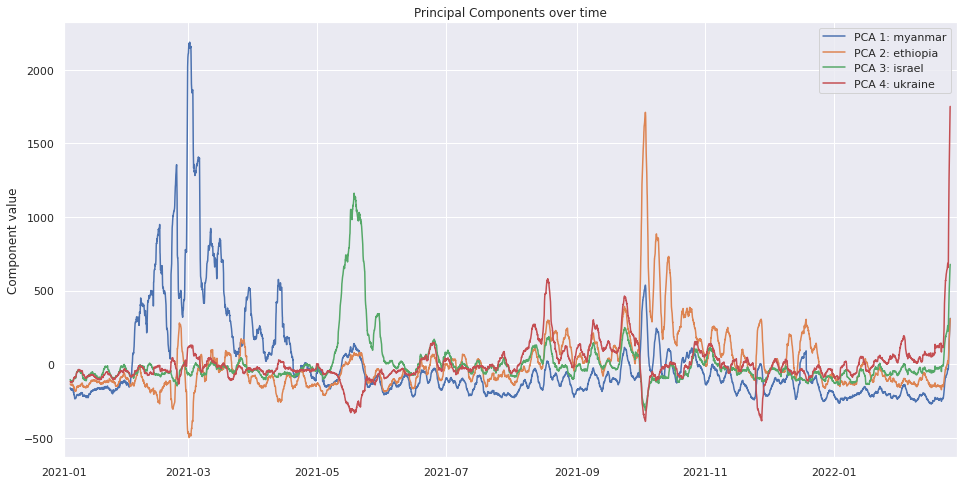

In [30]:
plt.plot(window_index[:,1],top10_dyn_tot_PCA[:,:len(var_comp_tot)]);
plt.gca().legend(top_topics_tot_PCA);
plt.xlim([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 2, 28)]);
plt.ylabel("Component value"); plt.title("Principal Components over time");

When looking at each of those topics over time, one can see that they are tightly correlated with the principal components and indeed contribute to some of the largest peaks in the overall sliding window.

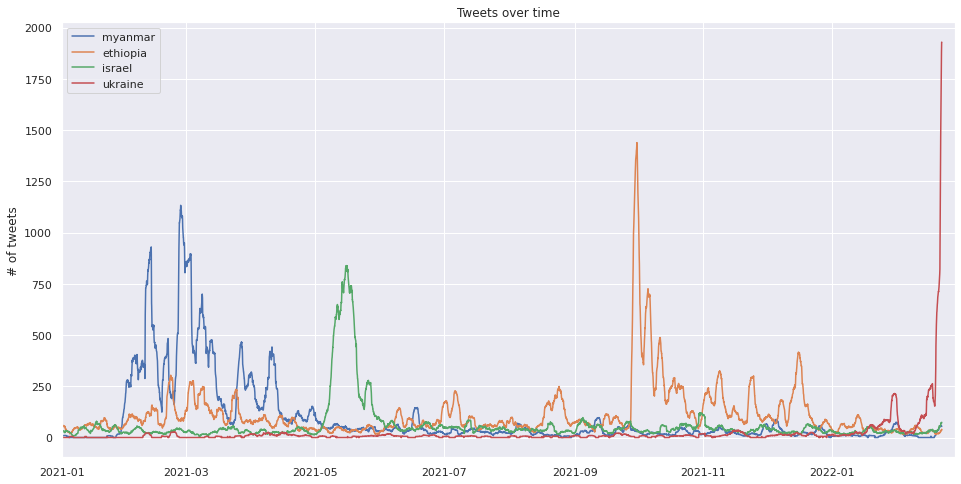

In [31]:
top_words_tot_dict = [dict(pos) for pos in top_words_tot]
top_words_tot_dyn = np.array([[dicts.get(top_topics_tot[i], 0) for dicts in top_words_tot_dict]
                          for i in range(len(var_comp_tot))]).T
plt.plot(window_index[:,0],top_words_tot_dyn)
plt.gca().legend(top_topics_tot)
plt.xlim([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 2, 28)]);
plt.ylabel("# of tweets"); plt.title("Tweets over time");

### Positive tweets <a class="anchor" id="positive-PCA"></a>
The same analysis on Negative and Neutral tweets resulted in roughly the same results, with the only other interesting result coming when analysing positive tweets, which as discussed above are proportionally fewer than the negative or neutral tweets. This also results in four components as seen below, which will be explored in a similar manner.

In [32]:
pca_pos = decomposition.PCA(n_components=0.95)
pca_pos.fit(top10_dyn_pos.T)
top10_dyn_pos_PCA = pca_pos.fit_transform(top10_dyn_pos.T)
var_comp_pos = pca_pos.explained_variance_ratio_[pca_pos.explained_variance_ratio_ >= 0.05]
print(var_comp_pos)

pca_topics_pos = [np.array(top10_pos)[np.flip(np.argsort(component))][:np.sum(np.flip(np.sort(component)) > 0.1)-1]
for component in pca_pos.components_]
top_topics_pos = [topics[0] for topics in pca_topics_pos][:len(var_comp_pos)]
top_topics_pos_PCA = ['PCA '+str(i+1)+': '+topics[0] for i, topics in enumerate(pca_topics_pos)][:len(var_comp_pos)]

[0.27456887 0.08030385 0.07387047 0.0560741 ]


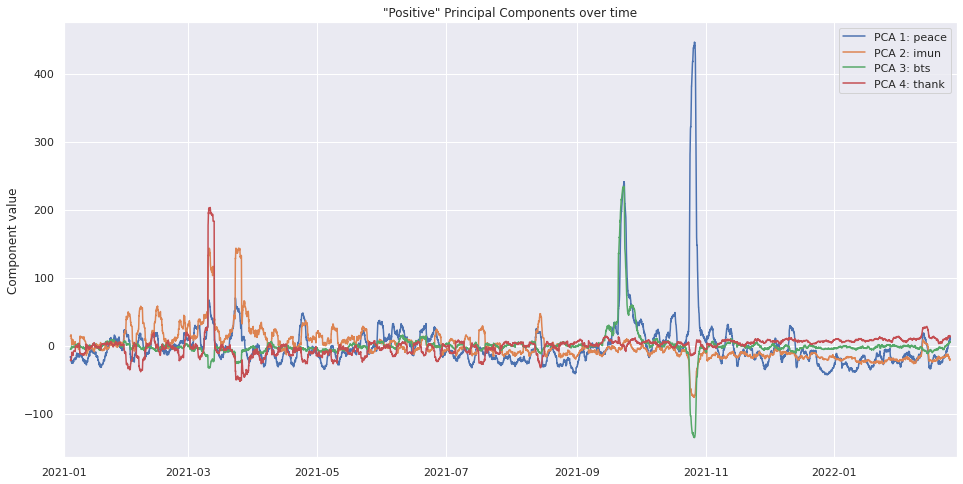

In [33]:
plt.plot(window_index[:,1],top10_dyn_pos_PCA[:,:len(var_comp_pos)]);
plt.gca().legend(top_topics_pos_PCA);
plt.xlim([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 2, 28)]);
plt.ylabel("Component value"); plt.title('"Positive" Principal Components over time');

In [34]:
print(pca_topics_pos[3][:2])

['thank' 'women']


I found this interesting as I was completely unaware of any of the topics here, so I shall detail them:

1. peace - Relates to two peaks, one during the opening of the  UN general assembly and the second during the official United Nations day, where messages of peace were shared. (https://en.wikipedia.org/wiki/Seventy-sixth_session_of_the_United_Nations_General_Assembly & https://en.wikipedia.org/wiki/United_Nations_Day)
2. imun - A model united nations which involves students simulating conflicts related to the UN, I can imagine young students engaged with social media and relating positively regarding their experiences in discussing with each other. It also involved a lot of social media promotion leading up to the event explaining a lack of a concrete peak. (No Wikipedia page: https://www.internationalmun.org)
3. bts - I initiall thought this was some token error such as with "amp" which Twitter returned in the presence of the symbol "&". After analysing the tweets I realised this relates to popular Korean K-Pop band BTS who performed and spoke at the UN to much social media response during the UN General assembly. (https://en.wikipedia.org/wiki/BTS)
4. thank - Relates to international women's day, as the second most contributing word indicates above, I considered removing the word "thank" to remove the second word "women" but I think it's sufficiently distinctive to keep, as many of the tweets relate to thanking women. (https://en.wikipedia.org/wiki/International_Women's_Day)

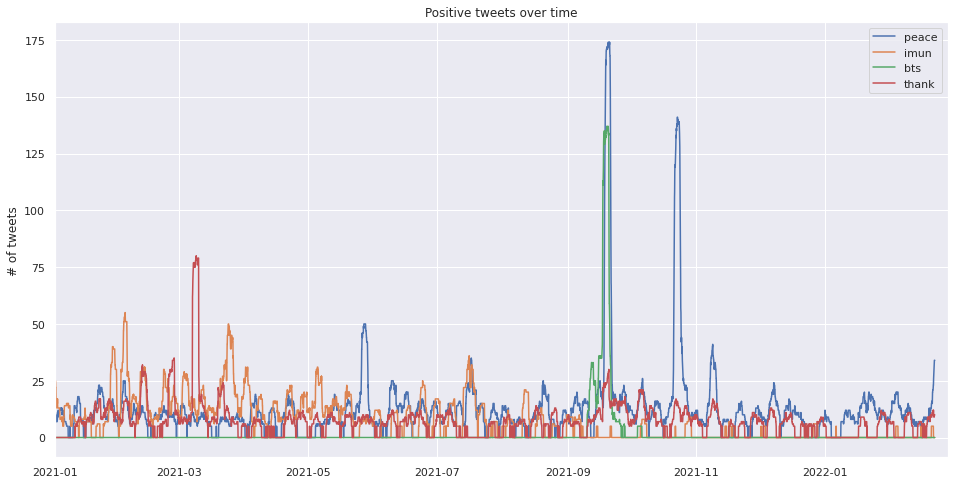

In [35]:
top_words_pos_dict = [dict(pos) for pos in top_words_pos]
top_words_pos_dyn = np.array([[dicts.get(top_topics_pos[i], 0) for dicts in top_words_pos_dict]
                          for i in range(len(var_comp_pos))]).T
plt.plot(window_index[:,0],top_words_pos_dyn)
plt.gca().legend(top_topics_pos)
plt.xlim([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 2, 28)]);
plt.ylabel("# of tweets"); plt.title("Positive tweets over time");

## Finding all trends: Hierarchical Clustering <a class="anchor" id="find-clustering"></a>
I then decide that while PCA worked well to get the biggest trends, in order to be thorough one must use a method to systematically find and cluster peaks.

For the first step I normalised the dynamics of the chosen keywords and kept only those that at any point in time were tweeted 25 times more than their usual median, or more than 100 times if their median was 0. This provided all the positions of what I would consider a peak or an above background amount of tweets.

97


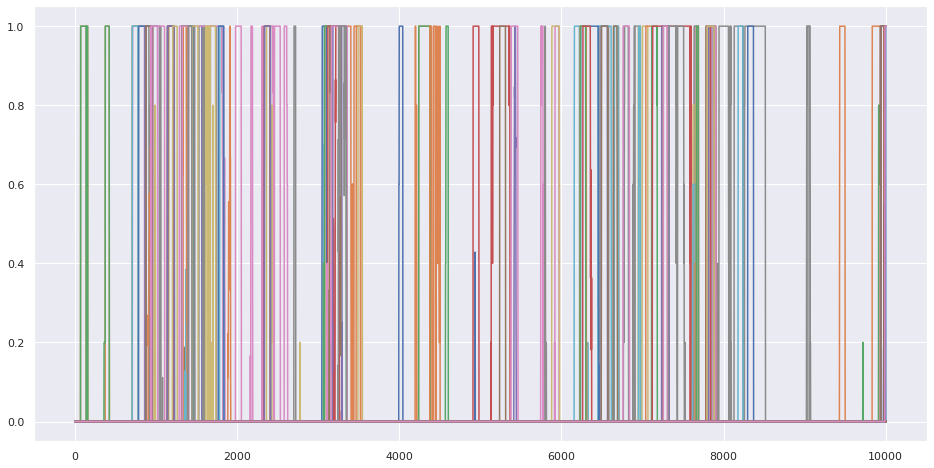

In [36]:
test = np.array([np.clip(feature / max(np.median(feature),5) - 20, 0, 1) for feature in top10_dyn_tot])
peak_rows = np.array([row for row in test if np.sum(row > 0)])
peak_row_names = np.array([top10_tot[i] for i,row in enumerate(test) if np.sum(row > 0)])

plt.plot(peak_rows.T);
print(len(peak_rows))

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In order to decide how to compare the sequences, I took a bit of inspiration from my course in Natural Language Processing. In said field when one wants to compare words, the words are embedded into a one-shot format, and the cosine similarity is used to classify the distance between words *ie* how similar or different they are. This seems ideal for this context, as I can identify for every given word, where it appears in time and then compare to every other word.

For this approach I then simply converted every word's dynamics to a vector of zero's and one's, where one would mean that word is expressed at least 20 times more than their median overall at that position in time, as mentioned above. I then used hierarchical clustering as provided by SciKit-Learn with cosine affinity and single linkage. I reasoned that hierarchical clustering should work well in this scenario as it is likely some trends are subsets of other trends or some trends are pleiotropic and overlap with multiple other trends, so hierarchical clustering could help to sort things out correctly.

Note: I think other clustering methods could also work well as long as they use a cosine distance based metric or something with a similar intuition.

In [38]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

def llf(id):
    if id <= 96:
        return str(peak_row_names[id])
    else:
        return '[%d %s]' % (id, 'beep')

With hierarchical clustering it is often useful to represent clusters via a dendogram as below, and while it is a bit unwieldly it gives an idea of what the algorythm has done. We can already envisage sensible clusters and below I will classify them. The distance threshold is by default 0.7, and I found after fiddling with it for a while that it is actually a reasonable choice for this dataset.

/home/eggman/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128250 (\N{TELEVISION}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


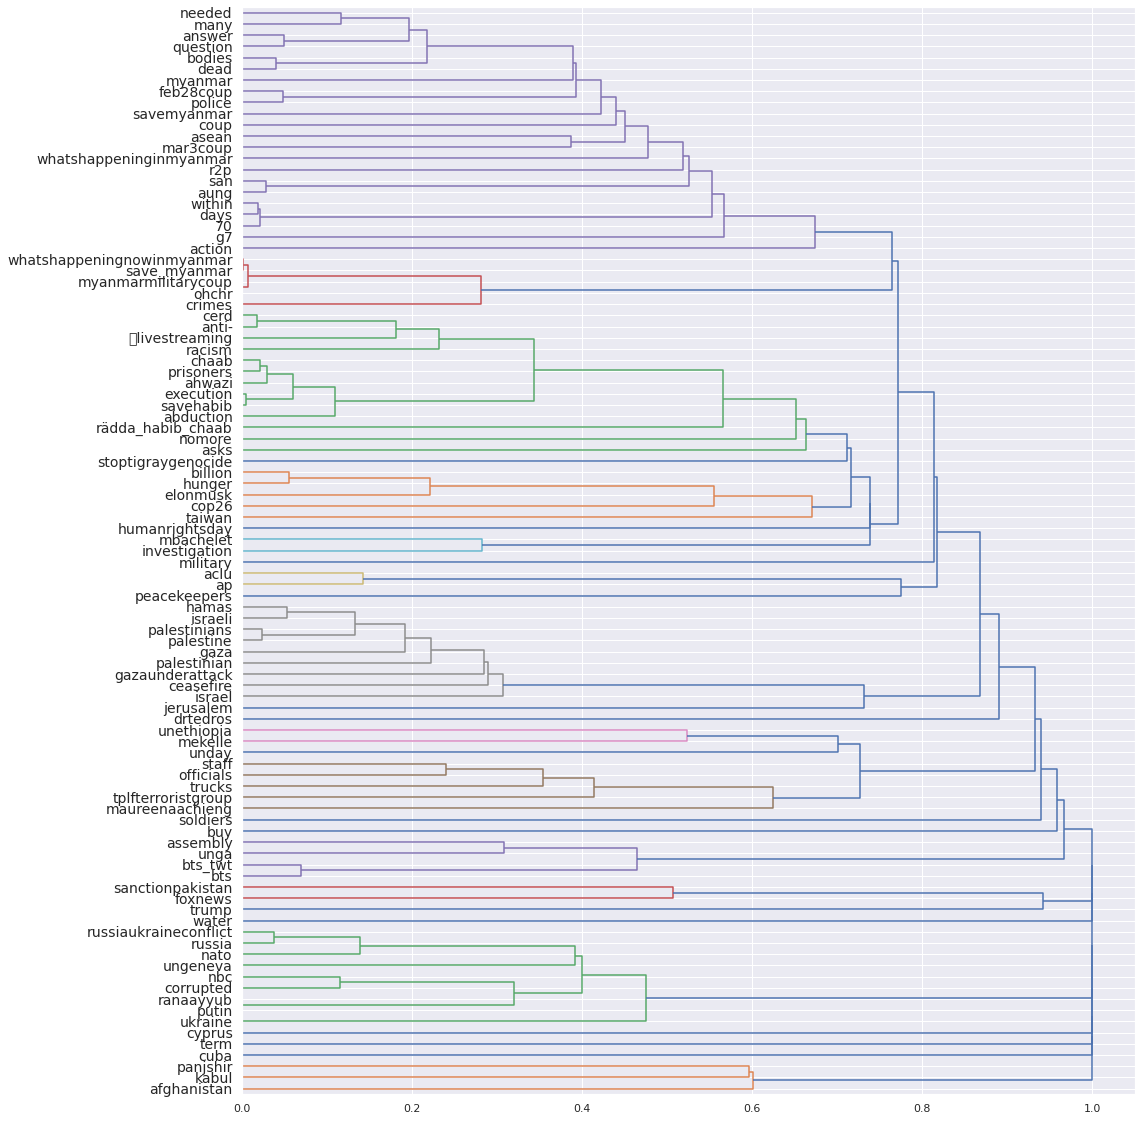

In [39]:
cos_dis_thrs = 0.7
clustering = AgglomerativeClustering(distance_threshold=cos_dis_thrs, n_clusters=None,
                                linkage='single', affinity='cosine', compute_distances=True)
clustering = clustering.fit(peak_rows)
plt.figure(figsize=(16, 20))
lm = plot_dendrogram(clustering, color_threshold = cos_dis_thrs, labels = peak_row_names, orientation = 'right',
                    leaf_font_size=14)

In [40]:
[print(i,peak_row_names[clustering.labels_ == i]) for i in range(clustering.n_clusters_) if 
 len(peak_row_names[clustering.labels_ == i]) > 1];

0 ['myanmar' 'coup' 'savemyanmar' 'aung' 'san' 'g7'
 'whatshappeninginmyanmar' 'many' 'action' 'dead' 'needed' 'bodies'
 'question' 'answer' 'police' 'feb28coup' 'mar3coup' 'r2p' 'days' '70'
 'within' 'asean']
1 ['afghanistan' 'kabul' 'panjshir']
2 ['taiwan' 'cop26' 'elonmusk' 'hunger' 'billion']
3 ['mekelle' 'unethiopia']
4 ['investigation' 'mbachelet']
5 ['racism' 'nomore' 'abduction' 'rädda_habib_chaab' 'ahwazi' 'anti-' 'cerd'
 '📺livestreaming' 'asks' 'savehabib' 'execution' 'prisoners' 'chaab']
6 ['israel' 'palestine' 'gaza' 'palestinians' 'gazaunderattack'
 'palestinian' 'israeli' 'hamas' 'ceasefire']
7 ['ap' 'aclu']
8 ['foxnews' 'sanctionpakistan']
9 ['crimes' 'ohchr' 'myanmarmilitarycoup' 'save_myanmar'
 'whatshappeningnowinmyanmar']
11 ['tplfterroristgroup' 'trucks' 'officials' 'staff' 'maureenaachieng']
18 ['unga' 'bts' 'bts_twt' 'assembly']
24 ['russia' 'nato' 'ungeneva' 'ukraine' 'corrupted' 'nbc' 'putin'
 'ranaayyub' 'russiaukraineconflict']


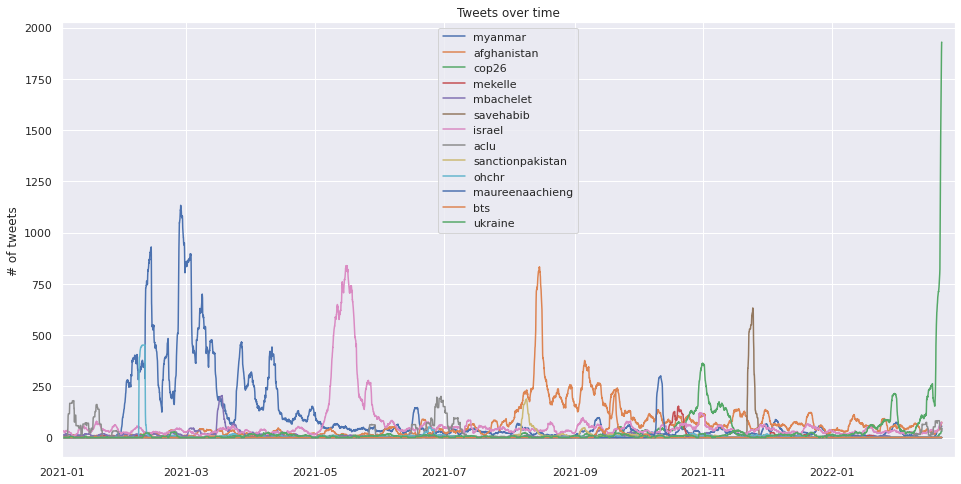

In [50]:
words_tot_clust = ['myanmar','afghanistan','cop26','mekelle','mbachelet','savehabib','israel','aclu',
                   'sanctionpakistan','ohchr','maureenaachieng','bts','ukraine']
words_tot_clust_dyn = np.array([[dicts.get(words_tot_clust[i], 0) for dicts in top_words_tot_dict]
                          for i in range(len(words_tot_clust))]).T
plt.plot(window_index[:,0],words_tot_clust_dyn)
plt.gca().legend(words_tot_clust)
plt.xlim([datetime.datetime(2021, 1, 1), datetime.datetime(2022, 2, 28)]);
plt.ylabel("# of tweets"); plt.title("Tweets over time");

I then focus on any cluster with more than two words associated to it and find the following trends/topics, some are very obvious, some I must dig into the tweets:
1. Myanmar coup d'état (above)
2. Afghanistan Panjshir conflict
3. COP26
4. Mekelle airstrikes in Tigray conflict (partially above)
5. UN High Commisioner for human rights Michelle Bachelet on Sri Lanka
6. The kidnapping of Swedish-Iranian Habib Chaab
7. Violence in Palestine and Israel (above)
8. Storming of the US capitol building
9. Call for sanctions to Pakistan pertaining to violence in Afghanistan
10. Myanmar coup d'etat (repeated, and above)
12. Tigray conflict more general (above)
19. BTS and UN general assembly (above)
25. Conflict in Ukraine (above)

As can be oberved, this method is more thorough than using PCA, the downside is that it requires a substantially greater degree of involvement. I need to be careful when choosing thresholds and how I cut off my data, what is a sensible background and what I consider a peak. These approaches can be automated to some degree, but to my knowledge it is not easy to establish a parameter-free peak finding algorythm. I don't show sorting by sentiment in this scenario as all of these topics except for those relating to BTS are negative!

## Summary <a class="anchor" id="summary"></a>
In summary I have analysed tweets ranging from the 1st of January 2021 to the 24th of February 2022 containing the #UN in English. Through a combination of statistics, deep learning, dimensionality reduction and clustering I have been able to distill the main talking points for twitter users as well as their sentiment in regards to these topics. Overall I have found that there is a substantial response to outbreaks of conflict, in particular those that receive extensive media coverage. I find 4 "large" trends that encompass many different subtopics and which received most of the attention of Twitter users, and 13 trends overall which had varying levels of response but all had clear peaks at specific timepoints.

Further avenues of research are to test these approaches on longer timescales to try to identify cyclic patterns, some being obvious such as relating to the opening of the general assembly each year; this may also identify the frequency of "trending" events related to the UN. Another interesting approach would be to try with different hashtags as controls, ideally one completely unrelated dataset and one closely related dataset to serve as negative and positive controls respectively. Overall I find this analysis useful to understand user response to political events and the results suggests this is a valid pipeline for extracting information regarding other topics on social media.